In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [13]:
df_analise = pd.read_csv('vendas2018_2023.csv')
#Ajuste Data e Valor
df_analise['data_venda'] = pd.to_datetime(df_analise['data_venda'], errors='coerce')
df_analise['valor_venda'] = pd.to_numeric(df_analise['valor_venda'], errors='coerce')
# Exclusão d linhas que não tenham cliente, data ou valor
df_analise.dropna(subset=['cliente', 'data_venda', 'valor_venda'], inplace=True)
df_analise['data_venda_dia'] = df_analise['data_venda'].dt.date
df_analise.rename(columns={
    'cliente': 'cliente_id', 
    'id': 'id_pedido'
}, inplace=True)
df_analise.head()

,id_pedido,data_venda,cliente_id,vendedor,produto,categoria,fornecedor,quantidade,valor_venda,valor_custo,data_venda_dia
0,1,2021-10-08,Victor Sousa,RODRIGO BIO,CAMA CASAL,MOVEIS,BRASIL MADEIRAS,2,1000.0,752.0,2021-10-08
1,2,2023-03-07,Giovana Cardoso,PEDRO NUNES,BARCO DE PEDRA,LIVROS,EDITORA AMAZONIA,2,37.0,20.0,2023-03-07
2,3,2022-07-24,Matheus Ferreira,MARCELO WITEMBERG,RIO DE JANEIRO / LIMA,PASSAGENS,LINHAS LATINAS DE AVIÃ•ES,1,1900.0,1570.0,2022-07-24
3,4,2022-01-07,Amanda Cavalcanti,FABIO AUGUSTO,LEITOR DE CARTOES MULTILASER,INFORMATICA,MULTILASER,2,24.0,11.0,2022-01-07
4,5,2020-03-09,Vinícius Silva,RODRIGO BIO,RIO DE JANEIRO / MIAMI,PASSAGENS,AMERICA LINES EXPRESS,4,1900.0,1763.0,2020-03-09


In [14]:
data_mais_atual = df_analise['data_venda_dia'].max() + timedelta(days=1)
print(f"Data de Referência para cálculo da Recência: {data_mais_atual}")

# Agrupar por cliente
df_agregado = df_analise.groupby('cliente_id').agg({
    'data_venda_dia': lambda x: (data_mais_atual - x.max()).days, # Recência: dias desde a última compra
    'id_pedido': 'count',                                         # Frequência: quantidade de pedidos
    'valor_venda': 'sum'                                          # Monetário: valor total gasto
})
df_agregado.rename(columns={
    'data_venda_dia': 'recencia', 
    'id_pedido': 'frequencia', 
    'valor_venda': 'monetario'
}, inplace=True)

df_agregado.head()

Data de Referência para cálculo da Recência: 2023-12-28


,recencia,frequencia,monetario
cliente_id,,,
Alex Alves,53,44,39481.0
Alex Araujo,76,27,14660.0
Alex Barbosa,137,51,52222.0
Alex Barros,36,41,42977.0
Alex Cardoso,17,19,13369.0


In [15]:
# R : Dividir em 5 grupos. Menor recência = Maior nota 
r_groups = pd.qcut(df_agregado['recencia'], q=5, labels=range(5, 0, -1))

# F: Maior frequência = Maior nota 
f_groups = pd.qcut(df_agregado['frequencia'].rank(method='first'), q=5, labels=range(1, 6))

# M: Maior valor = Maior nota 
m_groups = pd.qcut(df_agregado['monetario'], q=5, labels=range(1, 6))

df_agregado['R'] = r_groups.astype(int)
df_agregado['F'] = f_groups.astype(int)
df_agregado['M'] = m_groups.astype(int)

# Criar o RFM Score 
df_agregado['RFM_Score'] = df_agregado['R'] + df_agregado['F'] + df_agregado['M']
df_agregado['RFM_Segment'] = df_agregado['R'].astype(str) + df_agregado['F'].astype(str) + df_agregado['M'].astype(str)

df_agregado[['recencia', 'frequencia', 'monetario', 'R', 'F', 'M', 'RFM_Segment']].head()

,recencia,frequencia,monetario,R,F,M,RFM_Segment
cliente_id,,,,,,,
Alex Alves,53,44,39481.0,2,4,3,243
Alex Araujo,76,27,14660.0,2,1,1,211
Alex Barbosa,137,51,52222.0,1,5,5,155
Alex Barros,36,41,42977.0,3,4,4,344
Alex Cardoso,17,19,13369.0,4,1,1,411


In [16]:
def classify_by_segment(segment):
    r, f, m = int(segment[0]), int(segment[1]), int(segment[2])
    
    # 1. VIP (Comprou recentemente, compra sempre, gasta muito)
    if r >= 4 and f >= 4 and m >= 4:
        return 'Clientes VIP'
    
    # 2.  LEAIS (Bons compradores, frequentes)
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Clientes Leais'
    
    # 3. NOVOS CLIENTES (Comprou muito recentemente, mas tem pouca frequência)
    # R alto , mas F baixo 
    elif r >= 4 and f <= 2:
        return 'Novos Clientes'
    
    # 4. PROMESSAS (Recência e Monetário bons, mas ainda não comprou muitas vezes)
    elif r >= 3 and m >= 3:
        return 'Clientes Promissores'
    
    # 5. PERDIDOS (Faz tempo que não vem, comprou pouco e gastou pouco)
    elif r == 1 and f == 1 and m == 1:
        return 'Clientes Perdidos'
    
    # 6. EM RISCO (Recência baixa ou média, F e M baixos)
    elif r <= 2 and f <= 2 and m <= 2: 
         return 'Clientes em Risco'
    
    # 7. QUASE PERDIDOS (Clientes bons que pararam de comprar recentemente)
    elif r <= 2 and f >= 3 and m >= 3:
        return 'Quase Perdidos'
    # Recência baixa (1 ou 2), mas F ou M eram altos (4 ou 5)
    elif r <= 2 and (f >= 4 or m >= 4):
        return 'Em Risco (Ex-VIP)'

    # Resto
    else:
        return 'Outros'

df_agregado['Classe_Segmento'] = df_agregado['RFM_Segment'].apply(classify_by_segment)
print(df_agregado['Classe_Segmento'].value_counts())

Classe_Segmento
Clientes Leais          169
Outros                  159
Clientes VIP            141
Quase Perdidos          135
Novos Clientes          123
Clientes em Risco        86
Clientes Perdidos        43
Em Risco (Ex-VIP)        22
Clientes Promissores     13
Name: count, dtype: int64


In [17]:
def acao_por_segmento(classe):
    # Segmentos de Alto Valor
    if classe == 'Clientes VIP':
        return 'Dar tratamento VIP, acesso antecipado e gerente de conta.'
    elif classe == 'Clientes Leais':
        return 'Programa de fidelidade e ofertas de Cross-Sell.'
    elif classe == 'Clientes Promissores':
        return 'Oferecer descontos progressivos para aumentar o ticket médio.'
    
    # Segmentos de Retenção / Entrada
    elif classe == 'Novos Clientes':
        return 'Onboarding: Enviar cupom de 2ª compra e tutorial de produtos.'
    
    # Segmentos de Risco / Recuperação
    elif classe == 'Em Risco (Ex-VIP)':
        return 'URGENTE: Contato pessoal/telefônico para entender o abandono.'
    elif classe == 'Quase Perdidos':
        return 'Campanha de reativação automática via e-mail/SMS.'
    elif classe == 'Clientes em Risco':
        return 'Enviar ofertas promocionais agressivas.'
    elif classe == 'Clientes Perdidos':
        return 'Tentar reconquista esporádica ou ignorar para economizar verba.'
    
    else:
        return 'Manter relacionamento padrão.'

df_agregado['Acao_Estrategica'] = df_agregado['Classe_Segmento'].apply(acao_por_segmento)

display(df_agregado[['Classe_Segmento', 'Acao_Estrategica']].sample(10))

,Classe_Segmento,Acao_Estrategica
cliente_id,,
Martim Pereira,Clientes Promissores,Oferecer descontos progressivos para aumentar ...
Emily Ferreira,Novos Clientes,Onboarding: Enviar cupom de 2ª compra e tutori...
Nicole Correia,Clientes Perdidos,Tentar reconquista esporádica ou ignorar para ...
Gabrielle Correia,Clientes Leais,Programa de fidelidade e ofertas de Cross-Sell.
Alice Azevedo,Novos Clientes,Onboarding: Enviar cupom de 2ª compra e tutori...
Luiza Pinto,Clientes Perdidos,Tentar reconquista esporádica ou ignorar para ...
Miguel Ferreira,Outros,Manter relacionamento padrão.
Maria Rocha,Novos Clientes,Onboarding: Enviar cupom de 2ª compra e tutori...
Thaís Santos,Clientes VIP,"Dar tratamento VIP, acesso antecipado e gerent..."


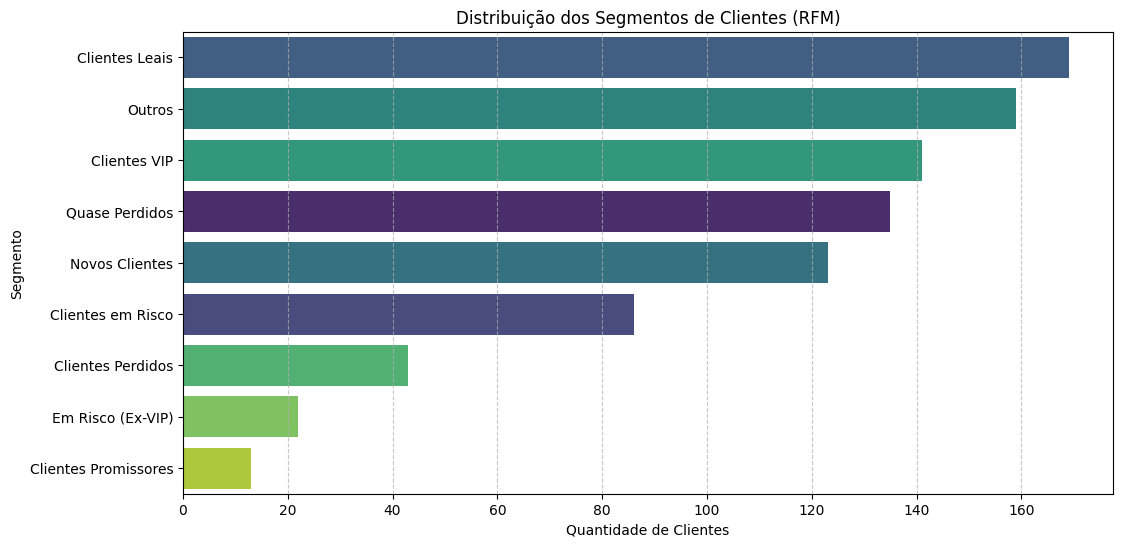

In [18]:
plt.figure(figsize=(12, 6))

sns.countplot(
    y='Classe_Segmento', 
    data=df_agregado, 
    order=df_agregado['Classe_Segmento'].value_counts().index,
    palette='viridis',
    hue='Classe_Segmento', 
    legend=False           
)

plt.title('Distribuição dos Segmentos de Clientes (RFM)')
plt.xlabel('Quantidade de Clientes')
plt.ylabel('Segmento')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()